In [132]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [133]:
# exemples de valeurs 

q=2 #nombre de noeuds
P_i   = [8, 2]         
c_i   = [3,8]       # coût par noeud
D_i   = [3,1]  

In [134]:
# Génération des variables x(i,j) pour i correspond au ième noeud, j est le jème indicateur de g_i
liste = list(range(q))


x_vars = []
for i in liste:
    if P_i[i] > 0:
        for s in range(int(np.ceil(np.log2(P_i[i]+1)))):
            x_vars.append((i, s))
    else:
        x_vars.append((i, 0))

"""c_vars = []
for i in liste:
    if P_i[i] > 0:
        for s in range(int(np.ceil(np.log2(P_i[i])))):
            c_vars.append((i, s))
    else:
        c_vars.append((i, 0))"""

qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
"""all = x_vars + c_vars 
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
offset = len(x_vars)
for k, (i,m) in enumerate(c_vars):
    qubit_index[f"beta_{i}_{m}"] = offset + k"""
    

def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

nqubit=len(x_vars)
"""def idx_c(i,r):
    return qubit_index[f"c_{i}_{r}"]
nqubit=len(all)"""

print("nombre de qubits est: ", nqubit)

nombre de qubits est:  6


In [135]:
terms = []
lam =100000# pénalité
D = np.sum(D_i)
nqubit = len(x_vars)  # nombre total de qubits
const = 0.0

# Précalcul des valeurs 2^j pour chaque qubit
powers = [2**j for (_, j) in x_vars]
T = sum(powers)  # somme totale de toutes les valeurs 2^j


for idx, ((i, j), pow_j) in enumerate(zip(x_vars, powers)):
    coeff_linear = (c_i[i] * pow_j - 2 * lam * D * pow_j + lam * (pow_j**2)) / 2
    
    # Construction du terme Pauli
    pauli_term = ['I'] * nqubit
    pauli_term[idx] = 'Z'
    terms.append((''.join(pauli_term), -coeff_linear))  # Inversion de signe
    
    # Mise à jour de la constante
    const += coeff_linear



for a, (i, j) in enumerate(x_vars):
    pow_j = powers[a]
    for b, (k, l) in enumerate(x_vars):
        if b <= a:
            continue
            
        pow_l = powers[b]
        # Coefficient unique pour toutes les paires
        coeff_quad = lam * pow_j * pow_l
        
        # Construction du terme Pauli
        pauli_term = ['I'] * nqubit
        pauli_term[a] = 'Z'
        pauli_term[b] = 'Z'
        terms.append((''.join(pauli_term), coeff_quad))
        
        # Mise à jour de la constante
        const += coeff_quad

# Ajout des termes manquants (d'après le développement mathématique)
const += lam * (D**2 - D * T + 0.25 * T**2)

# Ajout du terme constant global
terms.append(('I' * nqubit, const))

In [136]:
H_c = SparsePauliOp.from_list(terms)

In [137]:
from qiskit.quantum_info import SparsePauliOp

H_M = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(nqubit-i-1), 1.0)
    for i in range(nqubit)
])

print(H_M)

SparsePauliOp(['XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [138]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition

In [139]:
from qiskit import QuantumCircuit

def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 

In [140]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
cost_h=H_c
mixer_h=H_M

backend = Aer.get_backend('aer_simulator')
p=2
def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval)  

In [ ]:
%matplotlib inline
import time
import numpy as np
from collections import Counter
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ============
# Paramètres
# ============
target_bitstring = "001000"    # combinaison recherchée
p_max = 100               # profondeur maximale
tolerance = 1e-6             # tolérance optimisation

# ============
# Fonctions nécessaires (à définir si pas déjà faites)
# ============
# -> qaoa_expectation(params)  : fonction de coût
# -> build_qaoa_circuit(nqubit, p, gammas, betas, cost_h, mixer_h)

# ============
# Boucle adaptative sur p
# ============
start = time.time()
optimal_depth = None
found = False

for p in range(1, p_max+1):

    # Initialisation des paramètres
    gammas = np.linspace(0, np.pi, p) 
    betas = np.linspace(0, np.pi/2, p)
    params = np.concatenate([gammas, betas])

    # Optimisation QAOA
    result = minimize(qaoa_expectation, params, method='COBYLA', tol=tolerance)

    gammas_opt = result.x[:p]
    betas_opt = result.x[p:]

    # Construction du circuit
    qc = build_qaoa_circuit(nqubit, p, gammas_opt, betas_opt, cost_h, mixer_h)
    qc.measure_all()
    qc_transpiled = transpile(qc, AerSimulator())

    # Simulation
    job = AerSimulator().run(qc_transpiled, shots=2048)
    result_new = job.result()
    counts = result_new.get_counts()

    # Vérifier si la cible est le bitstring le plus probable
    top_bitstring, top_freq = Counter(counts).most_common(1)[0]
    print(f"Profondeur {p} → Top résultat = {top_bitstring} ({top_freq} occurrences)")

    if top_bitstring == target_bitstring:
        optimal_depth = p
        found = True
        break

end = time.time()

# ============
# Résultats finaux
# ============
if found:
    print(f"\n✅ Configuration {target_bitstring} trouvée à la profondeur optimale p = {optimal_depth}")
else:
    print(f"\n❌ Configuration {target_bitstring} NON trouvée jusqu’à p = {p_max}")

print("Temps d'exécution total :", round(end - start, 2), "secondes")


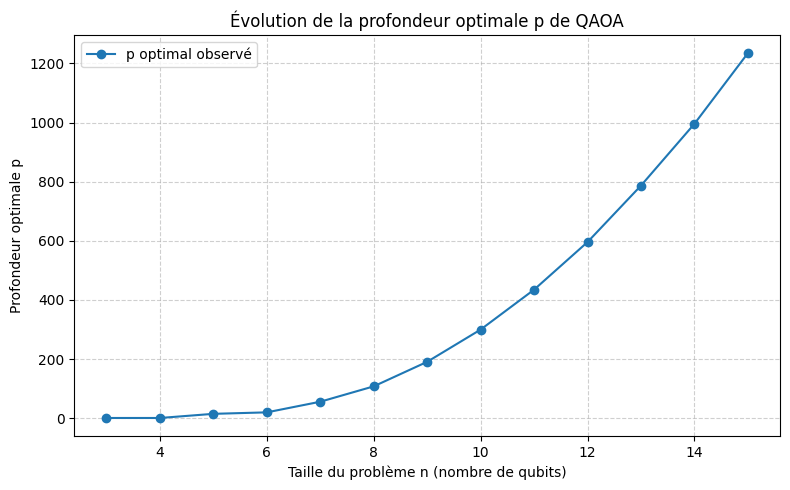

In [ ]:
import matplotlib.pyplot as plt

# Données fournies
n_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
p_values = [1, 1, 15, 20, 56, 108, 191, 300, 435, 596, 787, 996, 1235]

# Tracé
plt.figure(figsize=(8,5))
plt.plot(n_values, p_values, marker="o", linestyle="-", label="p optimal observé")

plt.title("Évolution de la profondeur optimale p de QAOA")
plt.xlabel("Taille du problème n (nombre de qubits)")
plt.ylabel("Profondeur optimale p")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()